In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import segmentation_models as sm

2023-01-01 10:11:53.162402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 10:11:55.734181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-01 10:11:55.734479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-01 10:11:55.734510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Segmentation Models: using `tf.keras` framework.


In [3]:
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1048085717579938', creation_time=1668775123782, experiment_id='1048085717579938', last_update_time=1669805000133, lifecycle_stage='active', name='/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation', tags={'mlflow.experiment.sourceName': '/Users/danimar301@student.polsl.pl/Extraterrestial-Rock-Segmentation',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'danimar301@student.polsl.pl',
 'mlflow.ownerId': '7796760964070965'}>

In [4]:
# Prepare paths of input images and target segmentation masks
# RockA is a simple data set with a few rocks
# RockB is more challanging -- according to description on github
input_dir_rockA = "./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/images/Rock-A/"
target_dir_rockA = "./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/label/"

input_dir_rockB = "./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/Images/Rock-B/"
target_dir_rockB = "./Datasets/Mars_Rocks/MarsData-main/Data/Rock-B/label/"

img_size = (320,320)


rockA_input_img_paths = sorted([
    os.path.join(input_dir_rockA, fname)
    for fname in os.listdir(input_dir_rockA)
    if fname.endswith(".jpg")
])

#Sorting mask names in target folder
rockA_target_img_paths = sorted([
    os.path.join(target_dir_rockA, fname)
    for fname in os.listdir(target_dir_rockA)
    if fname.endswith(".png") and not fname.startswith(".")
])

rockB_input_img_paths = sorted([
    os.path.join(input_dir_rockB, fname)
    for fname in os.listdir(input_dir_rockB)
    if fname.endswith(".jpg")
])

#Sorting mask names in target folder
rockB_target_img_paths = sorted([
    os.path.join(target_dir_rockB, fname)
    for fname in os.listdir(target_dir_rockB)
    if fname.endswith(".png") and not fname.startswith(".")
])

print("Number of Rock-A input samples:", len(rockA_input_img_paths))
print("Number of Rock-A target samples:", len(rockA_target_img_paths))

for input_path, target_path in zip(rockA_input_img_paths[:10], rockA_target_img_paths[:10]):
    print(input_path, "|", target_path)
    
print("Number of Rock-B input samples:", len(rockB_input_img_paths))
print("Number of Rock-B target samples:", len(rockB_target_img_paths))

for input_path, target_path in zip(rockB_input_img_paths[:10], rockB_target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of Rock-A input samples: 201
Number of Rock-A target samples: 201
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/images/Rock-A/1516_1516ML0077220050604247E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/label/1516_1516ML0077220050604247E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/images/Rock-A/1516_1516MR0077180000204657E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/label/1516_1516MR0077180000204657E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/images/Rock-A/1518_1518ML0077330000604252E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/label/1518_1518ML0077330000604252E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/images/Rock-A/1518_1518ML0077330050604257E01_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/label/1518_1518ML0077330050604257E01_DXXX.png
./Datasets/Mars_Rocks/MarsData-main/Data/Rock-A/images/Rock-A/1518_1518ML0077330060604258E02_DXXX.jpg | ./Datasets/Mars_Rocks/MarsData-

In [5]:
# auxiliary utility functions
def extract_mask_from_ground(ground_img, lower_color_threshold):
    (R, G, B) = cv2.split(ground_img)
    
    # Values are clipped as it is a binary classification problem
    R_ranged = np.clip(cv2.inRange(R, lower_color_threshold, 255), 0, 1) 
    G_ranged = np.clip(cv2.inRange(G, lower_color_threshold, 255), 0, 1) 
    B_ranged = np.clip(cv2.inRange(B, lower_color_threshold, 255), 0, 1)

    merged = cv2.merge([B_ranged, G_ranged, R_ranged])
    merged = np.expand_dims(merged, 3)
    merged = np.amax(merged, axis=2)
    return merged

# The threshold value determines how many small rocks are visible, higher threshold means less blue rocks
def load_ground(path, color_threshold):
    img_ground = cv2.imread(path)
    img_ground_rgb = cv2.cvtColor(img_ground, cv2.COLOR_BGR2RGB)
    img_ground_rgb = cv2.resize(img_ground_rgb, img_size[::-1])
    return extract_mask_from_ground(img_ground_rgb, color_threshold)

Input image: 


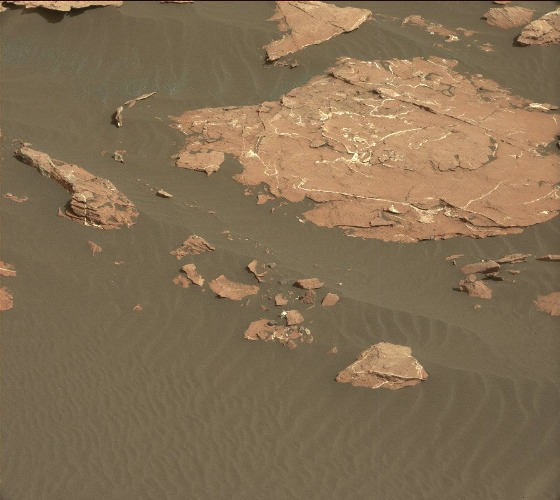

Target image: 


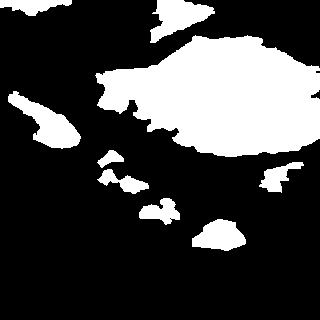

(320, 320, 1)
[0 1]


In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

image_index = 2

# Display input image 
print("Input image: ")
display(Image(filename=rockA_input_img_paths[image_index], width = 320, height = 320))

print("Target image: ")
img_ground = load_ground(rockA_target_img_paths[image_index], 1)
display(tf.keras.preprocessing.image.array_to_img(img_ground))

print(img_ground.shape)
print(np.unique(img_ground))

Input image: 


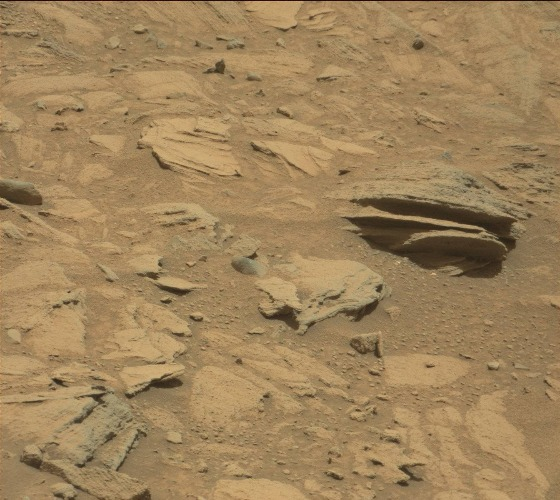

Target image: 


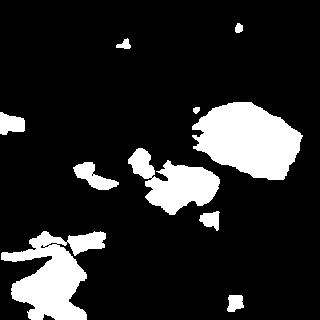

(320, 320, 1)
[0 1]


In [7]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

image_index = 2

# Display input image 
print("Input image: ")
display(Image(filename=rockB_input_img_paths[image_index], width = 320, height = 320))

print("Target image: ")
img_ground = load_ground(rockB_target_img_paths[image_index], 1)
display(tf.keras.preprocessing.image.array_to_img(img_ground))

print(img_ground.shape)
print(np.unique(img_ground))

In [16]:
from skimage import color
class MartianRocks(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, color_threshold):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.color_threshold = color_threshold
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            # load ground imahe
            y[j] = load_ground(path, self.color_threshold)
                
        return x, y
    
class MartianRocksGreyscaled(MartianRocks):
    
    def __getitem__(self, idx):
        # Returns tuple (input, target) corresponding to batch idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        # 3 Dimensional input images
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            img = color.rgb2gray(img)
            img =  np.repeat(img[..., np.newaxis], 3, -1)
            x[j] = img
                
        # 1 Dimensional target mask
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            # load ground imahe
            y[j] = load_ground(path, self.color_threshold)
                
        return x, y


<class 'tuple'>
[0 1]
<class 'numpy.uint8'>


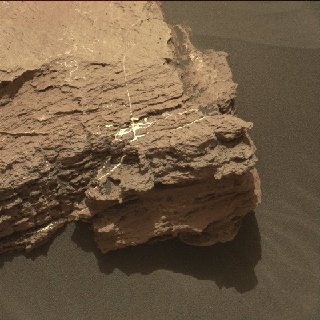

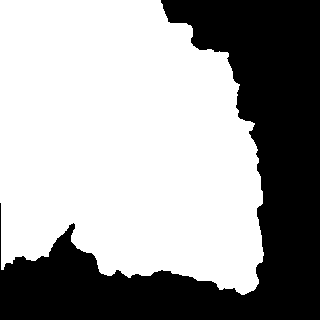

<class 'tuple'>
[0 1]
<class 'numpy.uint8'>


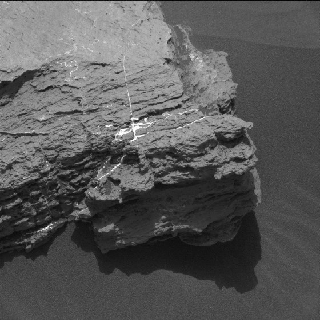

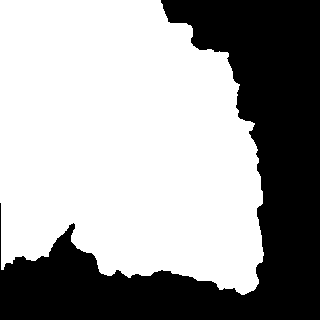

In [18]:
loader = MartianRocks(16, img_size, rockA_input_img_paths[:250], 
            rockA_target_img_paths[:250], color_threshold = 1)

print(type(loader.__getitem__(3)))
print(np.unique(loader.__getitem__(1)[1][1]))
print(type(loader.__getitem__(1)[1][3][0][0][0]))
batch = loader.__getitem__(2)
display(tf.keras.preprocessing.image.array_to_img(batch[0][1]))
display(tf.keras.preprocessing.image.array_to_img(batch[1][1]))

loaderGreyscaled = MartianRocksGreyscaled(
            16, img_size, rockA_input_img_paths[:250], 
            rockA_target_img_paths[:250], color_threshold = 1)

print(type(loaderGreyscaled.__getitem__(3)))
print(np.unique(loaderGreyscaled.__getitem__(1)[1][1]))
print(type(loaderGreyscaled.__getitem__(1)[1][3][0][0][0]))
batch = loaderGreyscaled.__getitem__(2)
display(tf.keras.preprocessing.image.array_to_img(batch[0][1]))
display(tf.keras.preprocessing.image.array_to_img(batch[1][1]))

In [19]:
rockA_generator = MartianRocks(16, img_size, rockA_input_img_paths[:250], 
            rockA_target_img_paths[:250], color_threshold = 1)

rockA_grayscaled_generator = MartianRocksGreyscaled(16, img_size, rockA_input_img_paths[:250], 
            rockA_target_img_paths[:250], color_threshold = 1)

rockB_generator = MartianRocks(16, img_size, rockB_input_img_paths[:250], 
            rockB_target_img_paths[:250], color_threshold = 1)

rockB_grayscaled_generator = MartianRocksGreyscaled(16, img_size, rockB_input_img_paths[:250], 
            rockB_target_img_paths[:250], color_threshold = 1)

In [95]:
from segmentation_models.losses  import bce_jaccard_loss
from segmentation_models.metrics import IOUScore

run_id = 0

# This line downloads models from mlflow artifacts
temp_dir = mlflow.artifacts.download_artifacts(
    'dbfs:/databricks/mlflow-tracking/1048085717579938/1d3ad8439094449b97c243e13928217c/artifacts/model')
print(temp_dir)
model = keras.models.load_model(temp_dir + '/data/model', compile=False)
model.summary()

/tmp/tmpa11dy087/model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 160, 160, 48  1296        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 160, 160, 48  192         ['stem_conv[0][0]']              
                                )                                      

 block2a_expand_activation (Act  (None, 160, 160, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 80, 80, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 80, 80, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 80, 80, 144)  0          ['block2a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
          

 block3a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block3a_se_squeeze[0][0]']     
                                                                                                  
 block3a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block3a_se_reshape[0][0]']     
                                                                                                  
 block3a_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block3a_se_reduce[0][0]']      
                                                                                                  
 block3a_se_excite (Multiply)   (None, 40, 40, 192)  0           ['block3a_activation[0][0]',     
                                                                  'block3a_se_expand[0][0]']      
                                                                                                  
 block3a_project_conv (Conv2D)  (None, 40, 40, 56)   10752       ['block3a_se_excite[0][0]']      
          

                                                                                                  
 block3c_project_bn (BatchNorma  (None, 40, 40, 56)  224         ['block3c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3c_drop (FixedDropout)    (None, 40, 40, 56)   0           ['block3c_project_bn[0][0]']     
                                                                                                  
 block3c_add (Add)              (None, 40, 40, 56)   0           ['block3c_drop[0][0]',           
                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 40, 40, 336)  18816       ['block3c_add[0][0]']            
          

                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 20, 20, 672)  2688       ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 20, 20, 672)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 20, 20, 672)  6048       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_b

 ivation)                                                                                         
                                                                                                  
 block4d_dwconv (DepthwiseConv2  (None, 20, 20, 672)  6048       ['block4d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 20, 20, 672)  2688       ['block4d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4d_activation (Activation  (None, 20, 20, 672)  0          ['block4d_bn[0][0]']             
 )                                                                                                
          

 block4f_bn (BatchNormalization  (None, 20, 20, 672)  2688       ['block4f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4f_activation (Activation  (None, 20, 20, 672)  0          ['block4f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4f_se_squeeze (GlobalAver  (None, 672)         0           ['block4f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4f_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block4f_se_squeeze[0][0]']     
          

                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5b_se_reduce[0][0]']      
                                                                                                  
 block5b_se_excite (Multiply)   (None, 20, 20, 960)  0           ['block5b_activation[0][0]',     
                                                                  'block5b_se_expand[0][0]']      
                                                                                                  
 block5b_project_conv (Conv2D)  (None, 20, 20, 160)  153600      ['block5b_se_excite[0][0]']      
                                                                                                  
 block5b_p

 block5d_se_excite (Multiply)   (None, 20, 20, 960)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 20, 20, 160)  153600      ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 20, 20, 160)  640        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_drop (FixedDropout)    (None, 20, 20, 160)  0           ['block5d_project_bn[0][0]']     
                                                                                                  
 block5d_a

 block5f_project_bn (BatchNorma  (None, 20, 20, 160)  640        ['block5f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5f_drop (FixedDropout)    (None, 20, 20, 160)  0           ['block5f_project_bn[0][0]']     
                                                                                                  
 block5f_add (Add)              (None, 20, 20, 160)  0           ['block5f_drop[0][0]',           
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 20, 20, 960)  153600      ['block5f_add[0][0]']            
                                                                                                  
 block6a_e

                                )                                                                 
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 10, 10, 1632  6528       ['block6c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block6c_expand_activation (Act  (None, 10, 10, 1632  0          ['block6c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6c_dwconv (DepthwiseConv2  (None, 10, 10, 1632  40800      ['block6c_expand_activation[0][0]
 D)                             )                                ']                               
          

 ization)                       )                                                                 
                                                                                                  
 block6e_expand_activation (Act  (None, 10, 10, 1632  0          ['block6e_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 10, 10, 1632  40800      ['block6e_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6e_bn (BatchNormalization  (None, 10, 10, 1632  6528       ['block6e_dwconv[0][0]']         
 )                              )                                                                 
          

 ivation)                       )                                                                 
                                                                                                  
 block6g_dwconv (DepthwiseConv2  (None, 10, 10, 1632  40800      ['block6g_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block6g_bn (BatchNormalization  (None, 10, 10, 1632  6528       ['block6g_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block6g_activation (Activation  (None, 10, 10, 1632  0          ['block6g_bn[0][0]']             
 )                              )                                                                 
          

 D)                             )                                ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 10, 10, 1632  6528       ['block7a_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block7a_activation (Activation  (None, 10, 10, 1632  0          ['block7a_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 1632)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
          

                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 20, 20, 256)  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 20, 20, 256)  0          ['decoder_stage0a_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, 20, 20, 256)  589824      ['decoder_stage0a_relu[0][0]']   
                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, 20, 20, 256)  1024       ['decoder_stage0b_conv[0][0]']   
 lization)

 decoder_stage3b_bn (BatchNorma  (None, 160, 160, 32  128        ['decoder_stage3b_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage3b_relu (Activati  (None, 160, 160, 32  0          ['decoder_stage3b_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, 320, 320, 32  0          ['decoder_stage3b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, 320, 320, 16  4608        ['decoder_stage4_upsampling[0][0]
          

In [96]:
# Generate predictions for rockA set
rockA_preds = model.predict(rockA_generator)

# Generate predictions for greyscaled rockA set
# rockA_greyscaled_preds = model.predict(rockA_grayscaled_generator)

# Generate predictions for rockB set
rockB_preds = model.predict(rockB_generator)

# Generate predictions for greyscaled rockB set
# rockB_greyscaled_preds = model.predict(rockB_grayscaled_generator)

12/12 [==============================] - 7s 632ms/step


In [37]:
from skimage import color
# Display results for validation image with index i

def get_mask(i, preds):
    #Quick utilization to display a model's prediction

    mask = np.argmax(preds[i], axis=2)
    mask = np.expand_dims(mask, axis=-1)
    mask = mask - 1 
    mask = np.clip(mask, 0, 1)
    # img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    return mask

def show_results(index, input_paths, target_paths, predictions):
    # Load input image
    # print(input_paths[index])
    # print(target_paths[index])
    original = cv2.imread(input_paths[index])
    display(tf.keras.preprocessing.image.array_to_img(original))
    original = cv2.resize(original, img_size)

    #Load ground-truth target mask
    target = load_ground(target_paths[index], 1)

    target_img = tf.keras.preprocessing.image.array_to_img(target)

    # Display mask predicted by model
    pred_mask = get_mask(index, predictions)

    pred_mask_img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))

    # Applay segmentation mask onto real image
    final_predicted = color.label2rgb(np.asarray(pred_mask_img), original, bg_label=0)
    final_target = color.label2rgb(np.asarray(target_img), original, bg_label=0)

    # Stack segmentation masks on real images
    final = np.hstack((final_target, final_predicted))

    # Stack only masks
    pred_mask = np.hstack((target, pred_mask))
    display(PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(pred_mask))) 

    display(tf.keras.preprocessing.image.array_to_img(final))

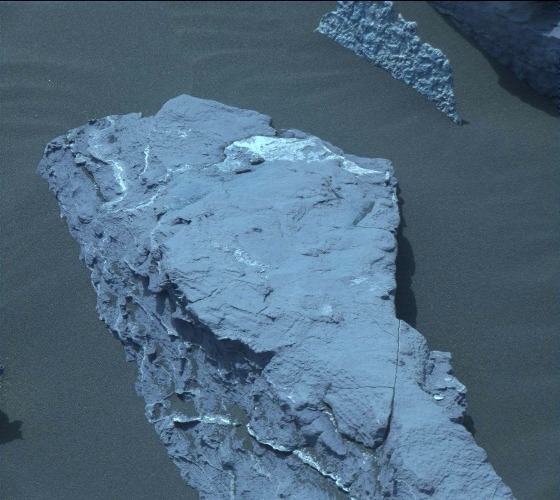

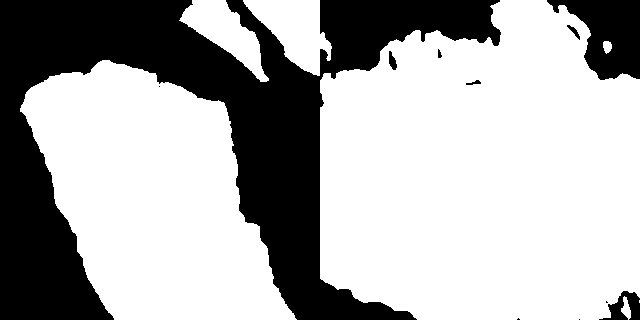

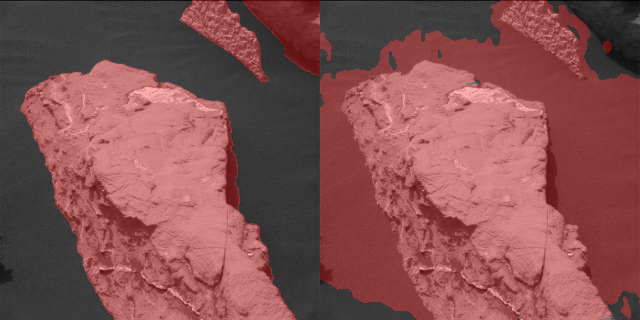

In [97]:
i = 5

show_results(i, rockA_input_img_paths, rockA_target_img_paths, rockA_preds)

In [24]:
# Utility function for evaluating models performance with any given metric
import keras.backend as K

# Calculate dice coefficent for one input array
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# Calculate average dice loss for every label
def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice = [0, 0]
    result = 0
    average = 0
    for index in range(numLabels):
        result = dice_coef(y_true[:,:,index], y_pred[:,:,index]) # @Todo: Zbierać dice score dla każdej klasy
        # print("Dice score for class {}: {}".format(index, result))
        dice[index] += result
        average += result
    return (dice, average/numLabels) # taking average

#@todo: make function for evaluating dice loss
def calculate_dice_loss(preds, target_paths, color_threshold=1):
    result = [0,0]
    average = []
    for i, mask in enumerate(preds):
        mask = np.argmax(mask, axis=2)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask - 1
        mask = np.clip(mask, 0, 1)
        target = cv2.imread(target_paths[i])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        target = cv2.resize(target, img_size[::-1])
        target = extract_mask_from_ground(target, color_threshold)

      #One hot encoding so the Dice coefficent works
        mask = tf.one_hot(mask, 2)
        mask = np.squeeze(mask, axis=2)
        target = tf.one_hot(target, 2)
        target = np.squeeze(target, axis=2)
#         print(mask.shape)
#         print(target.shape)
        dice_coef_tuple = dice_coef_multilabel(target, mask, 2)
        average.append(dice_coef_tuple[1])
        for i, value in enumerate(dice_coef_tuple[0]):
            result[i] += value

    for i, value in enumerate(result):
        print("Dice score for class {}: {}".format(i, value/len(preds)))
    return average

# Calculate metrics for all model predictions, returns a list 
def evaluate_model(preds, target_paths_here, metric, color_threshold=1):
    result = []
    metric.reset_states()
    for i, mask in enumerate(preds):
        mask = np.argmax(mask, axis=2)
        mask = np.expand_dims(mask, axis=-1)
        mask = mask - 1
        mask = np.clip(mask, 0, 1)
#         print(np.unique(mask))
        target = cv2.imread(target_paths_here[i])
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        target = cv2.resize(target, img_size[::-1])
        target = extract_mask_from_ground(target, color_threshold)

        metric.update_state(target, mask)
        result.append(metric.result().numpy())
    return result



In [25]:
def eval_preds(preds, img_paths, metric_name="", color_threshold = 1):
    # Define metrics
    meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
    accuracy = tf.keras.metrics.Accuracy()
    rmse = tf.keras.metrics.RootMeanSquaredError()

    # Calculate metrics for validation set
    dice_loss = np.mean(calculate_dice_loss(preds, img_paths, color_threshold))
    iou = np.mean(evaluate_model(preds, img_paths, meanIoU, color_threshold))
    accuracy =  np.mean(evaluate_model(preds, img_paths, accuracy, color_threshold))
    rmse = np.mean(evaluate_model(preds, img_paths, rmse, color_threshold))

    metrics = [dice_loss, iou, accuracy, rmse]
    
    # Display metrics
    print("Dice score on {} set: {}".format(metric_name, dice_loss))
    print("Mean IoU on {} set: {}".format(metric_name, iou))
    print("Accuracy on {} set: {}".format(metric_name, accuracy))
    print("RMSE on {} set: {}".format(metric_name,rmse))
    print()

    return metrics

In [98]:
eval_preds(rockA_preds, rockA_target_img_paths, 'rockA')

# eval_preds(rockA_greyscaled_preds, rockA_target_img_paths, 'greyscaled rockA')

eval_preds(rockB_preds, rockB_target_img_paths, 'rockB')

# eval_preds(rockB_greyscaled_preds, rockB_target_img_paths, 'greyscaled rockB')

Dice score for class 0: 0.1441615034627987
Dice score for class 1: 0.4346747731311757
Dice score on rockA set: 0.2894181382969871
Mean IoU on rockA set: 0.24036550521850586
Accuracy on rockA set: 0.4080362319946289
RMSE on rockA set: 0.768059492111206

Dice score for class 0: 0.11268190838879079
Dice score for class 1: 0.47345389260628035
Dice score on rockB set: 0.29306790049753556
Mean IoU on rockB set: 0.195970356464386
Accuracy on rockB set: 0.3531794548034668
RMSE on rockB set: 0.8037617802619934



[0.29306790049753556, 0.19597036, 0.35317945, 0.8037618]

Todo: fix greyscaled generator